## a toy example of machine learning with spark

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pyspark import SparkContext

In [3]:
# initializing spark in python 
sc = SparkContext('local', 'pyspark')

#### Exploring the user dataset

In [4]:
# import the raw data 
user_data = sc.textFile("e:\\spark_example_data\\ml-100k\\u.user")

In [4]:
user_data.first()

u'1|24|M|technician|85711'

In [5]:
user_fields = user_data.map(lambda x: x.split("|"))

In [36]:
user_fields.take(10)

[[u'1', u'24', u'M', u'technician', u'85711'],
 [u'2', u'53', u'F', u'other', u'94043'],
 [u'3', u'23', u'M', u'writer', u'32067'],
 [u'4', u'24', u'M', u'technician', u'43537'],
 [u'5', u'33', u'F', u'other', u'15213'],
 [u'6', u'42', u'M', u'executive', u'98101'],
 [u'7', u'57', u'M', u'administrator', u'91344'],
 [u'8', u'36', u'M', u'administrator', u'05201'],
 [u'9', u'29', u'M', u'student', u'01002'],
 [u'10', u'53', u'M', u'lawyer', u'90703']]

In [60]:
num_users = user_fields.map(lambda x: x[0]).count()
num_users

943

In [62]:
num_genders = user_fields.map(lambda x: x[2]).distinct().count()
num_genders

2

In [63]:
num_occupations = user_fields.map(lambda x: x[3]).distinct().count()
num_occupations

21

In [64]:
num_zipcodes = user_fields.map(lambda x: x[4]).distinct().count()
num_zipcodes

795

In [66]:
print "Users: %d, genders: %d, occupations: %d, ZIP codes: %d" % (num_users, \
                                            num_genders, num_occupations, num_zipcodes)

Users: 943, genders: 2, occupations: 21, ZIP codes: 795


In [35]:
# use int() to transform string to int
ages = user_fields.map(lambda x: int(x[1])).collect()

In [137]:
pd.Series(ages).value_counts()

30    39
25    38
22    37
28    36
27    35
26    34
24    33
29    32
20    32
32    28
23    28
35    27
21    27
33    26
31    25
...
14    3
65    3
70    3
61    3
59    3
58    3
64    2
68    2
69    2
62    2
11    1
10    1
73    1
66    1
7     1
Length: 61, dtype: int64

In [100]:
ages[:5]

[24, 53, 23, 24, 33]

In [36]:
df = pd.DataFrame(ages, columns = ['age'])

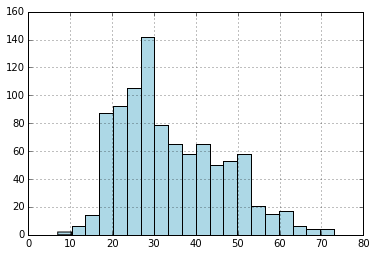

In [37]:
df.age.hist(bins = 20, color = 'lightblue');

In [50]:
user_fields.map(lambda x: x[2]).countByValue().items()

[(u'M', 670), (u'F', 273)]

In [107]:
count_by_occupation = user_fields.map(lambda x: (x[3], 1)).reduceByKey(lambda x, y: x + y).collect()
# similar to below code
# count_by_occupation = user_fields.map(lambda x: x[3]).countByValue().items()

In [108]:
count_by_occupation

[(u'administrator', 79),
 (u'writer', 45),
 (u'retired', 14),
 (u'student', 196),
 (u'doctor', 7),
 (u'entertainment', 18),
 (u'marketing', 26),
 (u'executive', 32),
 (u'none', 9),
 (u'scientist', 31),
 (u'educator', 95),
 (u'lawyer', 12),
 (u'healthcare', 16),
 (u'technician', 27),
 (u'librarian', 51),
 (u'programmer', 66),
 (u'artist', 28),
 (u'salesman', 12),
 (u'other', 105),
 (u'homemaker', 7),
 (u'engineer', 67)]

In [110]:
# sort dict by its valus
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])

In [117]:
# sort x_axis and y_axis by y_axis1
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

In [118]:
x_axis

array([u'doctor', u'homemaker', u'none', u'salesman', u'lawyer',
       u'retired', u'healthcare', u'entertainment', u'marketing',
       u'technician', u'artist', u'scientist', u'executive', u'writer',
       u'librarian', u'programmer', u'engineer', u'administrator',
       u'educator', u'other', u'student'], 
      dtype='<U13')

In [116]:
y_axis

array([  7,   7,   9,  12,  12,  14,  16,  18,  26,  27,  28,  31,  32,
        45,  51,  66,  67,  79,  95, 105, 196])

In [127]:
len(x_axis)

21

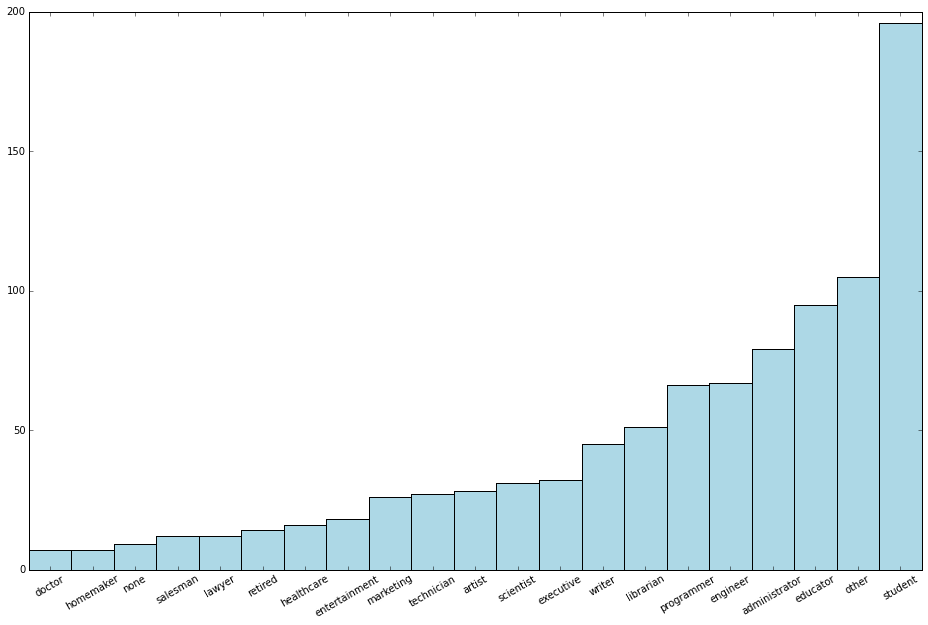

In [130]:
pos = np.arange(len(x_axis))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis, width, color = "lightblue")
plt.xticks(rotation = 30)
fig = plt.gcf()
fig.set_size_inches(16, 10);

#### Exploring the movie dataset

In [8]:
movie_data = sc.textFile("e:\\spark_example_data\\ml-100k\\u.item")

In [9]:
movie_data.first()

u'1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0'

In [10]:
print movie_data.first()

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0


In [11]:
movie_data.count()

1682

In [13]:
movie_fields = movie_data.map(lambda x: x.split("|"))

In [14]:
# deal with bad data in some lines 
def convert_year(x):
    try:
        return int(x[-4:])  # get the year from the right 
    except:
        return 1900

In [19]:
release_year = movie_fields.map(lambda x: x[2]).map(lambda x: convert_year(x))

In [21]:
years_filter = release_year.filter(lambda x: x != 1900)

In [22]:
release_year.count()

1682

In [23]:
years_filter.count()

1681

In [24]:
movie_ages = years_filter.map(lambda yr: 1998 - yr).countByValue()

In [41]:
movie_ages

defaultdict(<type 'int'>, {0: 65, 1: 286, 2: 355, 3: 219, 4: 214, 5: 126, 6: 37, 7: 22, 8: 24, 9: 15, 10: 11, 11: 13, 12: 15, 13: 7, 14: 8, 15: 5, 16: 13, 17: 12, 18: 8, 19: 9, 20: 4, 21: 4, 22: 5, 23: 6, 24: 8, 25: 4, 26: 3, 27: 7, 28: 3, 29: 4, 30: 6, 31: 5, 32: 2, 33: 5, 34: 2, 35: 6, 36: 5, 37: 3, 38: 5, 39: 4, 40: 9, 41: 8, 42: 4, 43: 5, 44: 7, 45: 2, 46: 3, 47: 5, 48: 7, 49: 4, 50: 3, 51: 5, 52: 5, 53: 4, 54: 5, 55: 4, 56: 2, 57: 5, 58: 8, 59: 7, 60: 3, 61: 4, 62: 2, 63: 4, 64: 4, 65: 2, 66: 1, 67: 1, 68: 1, 72: 1, 76: 1})

In [29]:
values = movie_ages.values()

In [30]:
bins = movie_ages.keys()

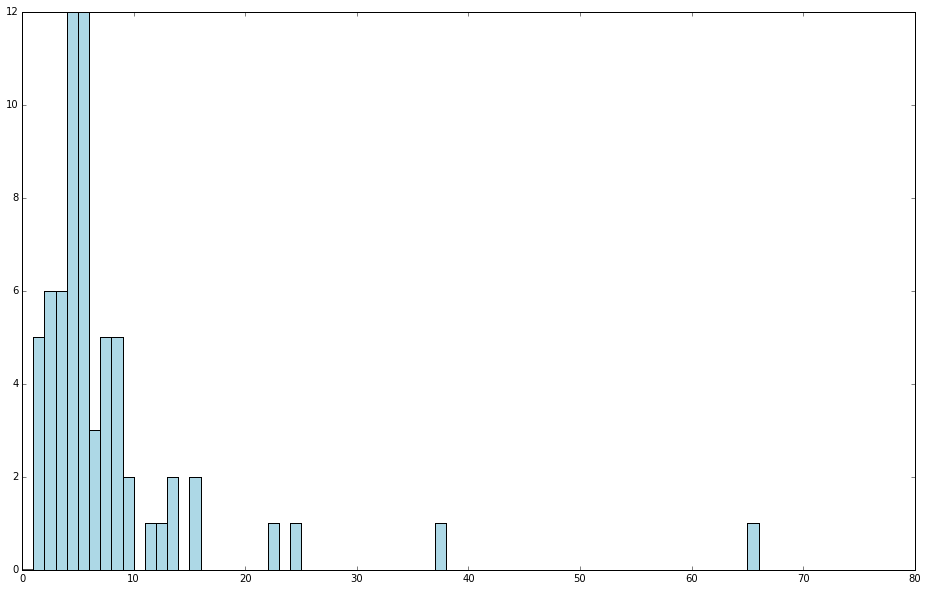

In [32]:
plt.hist(values, bins = bins, color = "lightblue")
fig = plt.gcf()
fig.set_size_inches(16, 10);

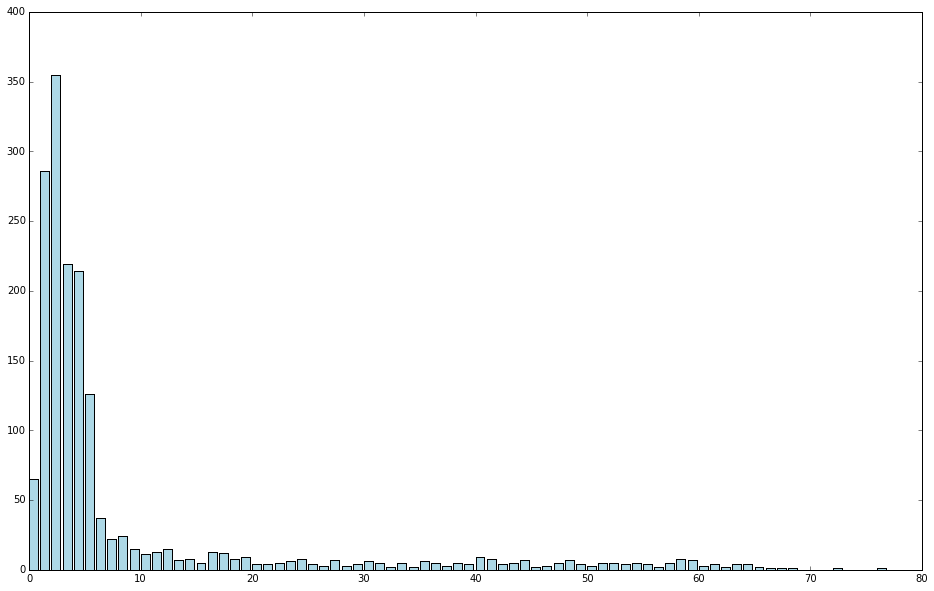

In [45]:
plt.bar(left = bins, height = values, color = "lightblue")
fig = plt.gcf()
fig.set_size_inches(16, 10);